In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import time
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

# ==================== DEVICE SETUP ====================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ==================== DATA LOADING ====================
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

Using device: cuda


In [7]:
# ==================== PART 1: CUSTOM CNN ====================
print("\n" + "="*60)
print("PART 1: CNN CLASSIFICATION")
print("="*60)

class CNN(nn.Module):
    def __init__(self, in_channels=1, num_classes=10):
        super(CNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

def train_cnn(model, train_loader, test_loader, num_epochs=5):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    start_time = time.time()
    train_losses, test_losses, train_accs, test_accs = [], [], [], []
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        running_loss = 0
        correct = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        # Testing
        model.eval()
        test_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        test_loss = test_loss / len(test_loader)
        test_acc = correct / total
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        
        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc*100:.2f}%")
    
    training_time = time.time() - start_time
    return model, train_losses, test_losses, train_accs, test_accs, training_time

# Train CNN
cnn_model = CNN().to(device)
cnn_model, cnn_train_loss, cnn_test_loss, cnn_train_acc, cnn_test_acc, cnn_time = train_cnn(cnn_model, train_loader, test_loader, num_epochs=5)

def evaluate_model(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    return accuracy, f1

cnn_final_acc, cnn_f1 = evaluate_model(cnn_model, test_loader)
print(f"\nCNN Final Results:")
print(f"Accuracy: {cnn_final_acc:.4f}")
print(f"F1 Score: {cnn_f1:.4f}")
print(f"Training Time: {cnn_time:.2f}s")
print(f"Final Test Loss: {cnn_test_loss[-1]:.4f}")


PART 1: CNN CLASSIFICATION
Epoch [1/5] - Train Loss: 0.1959, Train Acc: 93.86%, Test Loss: 0.0447, Test Acc: 98.52%
Epoch [2/5] - Train Loss: 0.0624, Train Acc: 98.12%, Test Loss: 0.0368, Test Acc: 98.73%
Epoch [3/5] - Train Loss: 0.0461, Train Acc: 98.58%, Test Loss: 0.0304, Test Acc: 98.97%
Epoch [4/5] - Train Loss: 0.0356, Train Acc: 98.90%, Test Loss: 0.0274, Test Acc: 99.14%
Epoch [5/5] - Train Loss: 0.0307, Train Acc: 98.98%, Test Loss: 0.0254, Test Acc: 99.16%

CNN Final Results:
Accuracy: 0.9916
F1 Score: 0.9916
Training Time: 71.72s
Final Test Loss: 0.0254


In [8]:
# ==================== PART 2: FASTER R-CNN (Real Object Detection) ====================
print("\n" + "="*60)
print("PART 2: FASTER R-CNN (Real Object Detection)")
print("="*60)

import torchvision
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Generate bounding boxes for MNIST digits
def generate_bbox(img):
    coords = torch.nonzero(img)
    if coords.shape[0] == 0:
        return [8, 8, 20, 20]
    y_min = coords[:,0].min().item()
    y_max = coords[:,0].max().item()
    x_min = coords[:,1].min().item()
    x_max = coords[:,1].max().item()
    return [x_min, y_min, x_max, y_max]

# Detection Dataset
class MNISTDetectionDataset:
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img = torch.tensor(self.images[idx], dtype=torch.float32)
        digit = int(self.labels[idx])
        img_rgb = img.repeat(3, 1, 1)  # Convert to RGB
        
        x_min, y_min, x_max, y_max = generate_bbox(img)
        label_det = digit + 1  # Classes: 1-10 (0=background)
        
        target = {
            "boxes": torch.tensor([[x_min, y_min, x_max, y_max]], dtype=torch.float32),
            "labels": torch.tensor([label_det], dtype=torch.long)
        }
        return img_rgb, target

# Data loaders for detection
def collate_fn(batch):
    return tuple(zip(*batch))

train_det_dataset = MNISTDetectionDataset(train_dataset.data.numpy(), train_dataset.targets.numpy())
test_det_dataset = MNISTDetectionDataset(test_dataset.data.numpy(), test_dataset.targets.numpy())

train_det_loader = DataLoader(train_det_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_det_loader = DataLoader(test_det_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

# Load pre-trained Faster R-CNN
model_frcnn = fasterrcnn_mobilenet_v3_large_fpn(weights="DEFAULT")

# Modify for MNIST (11 classes: background + 10 digits)
num_classes = 11
in_features = model_frcnn.roi_heads.box_predictor.cls_score.in_features
model_frcnn.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model_frcnn = model_frcnn.to(device)

# Training Faster R-CNN
optimizer_frcnn = optim.Adam(model_frcnn.parameters(), lr=0.001)
start_time = time.time()
frcnn_train_loss_list = []

for epoch in range(2):
    print(f"Epoch {epoch+1}/2")
    model_frcnn.train()
    total_loss = 0
    
    for imgs, targets in train_det_loader:
        imgs = [img.to(device) for img in imgs]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model_frcnn(imgs, targets)
        loss = sum(loss_dict.values())
        
        optimizer_frcnn.zero_grad()
        loss.backward()
        optimizer_frcnn.step()
        total_loss += loss.item()
    
    avg_loss = total_loss / len(train_det_loader)
    frcnn_train_loss_list.append(avg_loss)
    print(f"Loss: {avg_loss:.4f}")

frcnn_time = time.time() - start_time

# Evaluation Faster R-CNN
model_frcnn.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for imgs, targets in test_det_loader:
        imgs = [img.to(device) for img in imgs]
        outputs = model_frcnn(imgs)
        
        for out, t in zip(outputs, targets):
            if len(out["labels"]) == 0:
                pred_digit = -1
            else:
                pred_digit = out["labels"][0].item() - 1
            
            true_digit = t["labels"].item() - 1
            all_preds.append(pred_digit)
            all_labels.append(true_digit)
            total += 1
            if pred_digit == true_digit:
                correct += 1

frcnn_final_acc = correct / total if total > 0 else 0
frcnn_f1 = f1_score(all_labels, all_preds, average="macro", zero_division=0)

print(f"\nFaster R-CNN Final Results:")
print(f"Accuracy: {frcnn_final_acc:.4f}")
print(f"F1 Score: {frcnn_f1:.4f}")
print(f"Training Time: {frcnn_time:.2f}s")


PART 2: FASTER R-CNN (Real Object Detection)
Epoch 1/2
Loss: 0.5775
Epoch 2/2
Loss: 0.2413

Faster R-CNN Final Results:
Accuracy: 0.9863
F1 Score: 0.9862
Training Time: 2176.48s


In [9]:
# ==================== PART 3: COMPARISON ====================
print("\n" + "="*60)
print("PART 3: CNN vs FASTER R-CNN COMPARISON")
print("="*60)

comparison_data = {
    'CNN': {
        'Accuracy': cnn_final_acc,
        'F1 Score': cnn_f1,
        'Loss': cnn_test_loss[-1],
        'Time': cnn_time
    },
    'Faster R-CNN': {
        'Accuracy': frcnn_final_acc,
        'F1 Score': frcnn_f1,
        'Loss': 0,  # Detection doesn't use classification loss
        'Time': frcnn_time
    }
}

print(f"\n{'Model':<15} {'Accuracy':<15} {'F1 Score':<15} {'Time(s)':<15}")
print("-" * 60)
for model_name, metrics in comparison_data.items():
    print(f"{model_name:<15} {metrics['Accuracy']:.4f}         {metrics['F1 Score']:.4f}         {metrics['Time']:.2f}")


PART 3: CNN vs FASTER R-CNN COMPARISON

Model           Accuracy        F1 Score        Time(s)        
------------------------------------------------------------
CNN             0.9916         0.9916         71.72
Faster R-CNN    0.9863         0.9862         2176.48


In [10]:
# ==================== PART 4: FINE-TUNING PRE-TRAINED MODELS ====================
print("\n" + "="*60)
print("PART 4: FINE-TUNING VGG16 & ALEXNET")
print("="*60)

# Function to evaluate pretrained models (with resize + RGB conversion)
def evaluate_pretrained_model(model, test_loader, device):
    model.eval()
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for images, labels in test_loader:
            # Resize to 224x224 and convert to RGB (3 channels)
            images = transforms.Resize((224, 224))(images)
            images = torch.cat([images, images, images], dim=1)
            images = images.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    return accuracy, f1

# ==================== VGG16 FINE-TUNING ====================
print("\n--- VGG16 Fine-tuning ---")
vgg16_model = models.vgg16(weights='DEFAULT')

# Freeze early layers
for param in list(vgg16_model.parameters())[:-4]:
    param.requires_grad = False

# Modify classifier for MNIST (10 classes)
vgg16_model.classifier[6] = nn.Linear(4096, 10)
vgg16_model = vgg16_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_vgg = optim.Adam(filter(lambda p: p.requires_grad, vgg16_model.parameters()), lr=0.0001)

start_time = time.time()
vgg16_train_loss, vgg16_test_loss = [], []

for epoch in range(5):
    vgg16_model.train()
    running_loss = 0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        # Resize and convert to RGB
        images = transforms.Resize((224, 224))(images)
        images = torch.cat([images, images, images], dim=1)
        images, labels = images.to(device), labels.to(device)
        
        optimizer_vgg.zero_grad()
        outputs = vgg16_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_vgg.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    vgg16_train_loss.append(train_loss)
    
    # Test phase
    vgg16_model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = transforms.Resize((224, 224))(images)
            images = torch.cat([images, images, images], dim=1)
            images, labels = images.to(device), labels.to(device)
            outputs = vgg16_model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_loss = test_loss / len(test_loader)
    test_acc = correct / total
    vgg16_test_loss.append(test_loss)
    
    print(f"Epoch [{epoch+1}/5] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc*100:.2f}%")

vgg16_time = time.time() - start_time
vgg16_final_acc, vgg16_f1 = evaluate_pretrained_model(vgg16_model, test_loader, device)

print(f"\nVGG16 Final Results:")
print(f"Accuracy: {vgg16_final_acc:.4f}")
print(f"F1 Score: {vgg16_f1:.4f}")
print(f"Training Time: {vgg16_time:.2f}s")
print(f"Final Test Loss: {vgg16_test_loss[-1]:.4f}")


PART 4: FINE-TUNING VGG16 & ALEXNET

--- VGG16 Fine-tuning ---
Epoch [1/5] - Train Loss: 0.3024, Train Acc: 91.16%, Test Loss: 0.0811, Test Acc: 97.60%
Epoch [2/5] - Train Loss: 0.1175, Train Acc: 96.22%, Test Loss: 0.0706, Test Acc: 97.69%
Epoch [3/5] - Train Loss: 0.0985, Train Acc: 96.89%, Test Loss: 0.0590, Test Acc: 98.08%
Epoch [4/5] - Train Loss: 0.0864, Train Acc: 97.20%, Test Loss: 0.0553, Test Acc: 98.06%
Epoch [5/5] - Train Loss: 0.0813, Train Acc: 97.38%, Test Loss: 0.0443, Test Acc: 98.64%

VGG16 Final Results:
Accuracy: 0.9864
F1 Score: 0.9864
Training Time: 985.77s
Final Test Loss: 0.0443


In [11]:
# ==================== ALEXNET FINE-TUNING ====================
print("\n--- AlexNet Fine-tuning ---")
alexnet_model = models.alexnet(weights='DEFAULT')

# Freeze early layers
for param in list(alexnet_model.parameters())[:-4]:
    param.requires_grad = False

# Modify classifier for MNIST
alexnet_model.classifier[6] = nn.Linear(4096, 10)
alexnet_model = alexnet_model.to(device)

optimizer_alex = optim.Adam(filter(lambda p: p.requires_grad, alexnet_model.parameters()), lr=0.0001)

start_time = time.time()
alex_train_loss, alex_test_loss = [], []

for epoch in range(5):
    alexnet_model.train()
    running_loss = 0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images = transforms.Resize((224, 224))(images)
        images = torch.cat([images, images, images], dim=1)
        images, labels = images.to(device), labels.to(device)
        
        optimizer_alex.zero_grad()
        outputs = alexnet_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_alex.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    alex_train_loss.append(train_loss)
    
    # Test phase
    alexnet_model.eval()
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = transforms.Resize((224, 224))(images)
            images = torch.cat([images, images, images], dim=1)
            images, labels = images.to(device), labels.to(device)
            outputs = alexnet_model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    test_loss = test_loss / len(test_loader)
    test_acc = correct / total
    alex_test_loss.append(test_loss)
    
    print(f"Epoch [{epoch+1}/5] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc*100:.2f}%")

alex_time = time.time() - start_time
alex_final_acc, alex_f1 = evaluate_pretrained_model(alexnet_model, test_loader, device)

print(f"\nAlexNet Final Results:")
print(f"Accuracy: {alex_final_acc:.4f}")
print(f"F1 Score: {alex_f1:.4f}")
print(f"Training Time: {alex_time:.2f}s")
print(f"Final Test Loss: {alex_test_loss[-1]:.4f}")


--- AlexNet Fine-tuning ---


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 215MB/s] 


Epoch [1/5] - Train Loss: 0.2970, Train Acc: 90.92%, Test Loss: 0.0914, Test Acc: 97.13%
Epoch [2/5] - Train Loss: 0.1546, Train Acc: 95.00%, Test Loss: 0.0620, Test Acc: 98.05%
Epoch [3/5] - Train Loss: 0.1375, Train Acc: 95.54%, Test Loss: 0.0591, Test Acc: 98.20%
Epoch [4/5] - Train Loss: 0.1253, Train Acc: 95.75%, Test Loss: 0.0562, Test Acc: 98.19%
Epoch [5/5] - Train Loss: 0.1153, Train Acc: 96.25%, Test Loss: 0.0693, Test Acc: 97.78%

AlexNet Final Results:
Accuracy: 0.9778
F1 Score: 0.9779
Training Time: 265.16s
Final Test Loss: 0.0693


In [12]:
# ==================== COMPARISON WITH CNN & FASTER R-CNN ====================
print("\n" + "="*60)
print("FINAL COMPARISON: ALL 4 MODELS")
print("="*60)

# From previous parts (paste your results here)
cnn_final_acc = 0.9891  # From your PART 1
cnn_f1 = 0.9891
cnn_test_loss = [0.0317]
cnn_time = 72.38

frcnn_final_acc = 0.9853  # From your PART 2
frcnn_f1 = 0.9853
frcnn_time = 2113.98

final_results = {
    'CNN': {'Accuracy': cnn_final_acc, 'F1': cnn_f1, 'Loss': cnn_test_loss[-1], 'Time': cnn_time},
    'Faster R-CNN': {'Accuracy': frcnn_final_acc, 'F1': frcnn_f1, 'Loss': 0, 'Time': frcnn_time},
    'VGG16': {'Accuracy': vgg16_final_acc, 'F1': vgg16_f1, 'Loss': vgg16_test_loss[-1], 'Time': vgg16_time},
    'AlexNet': {'Accuracy': alex_final_acc, 'F1': alex_f1, 'Loss': alex_test_loss[-1], 'Time': alex_time}
}

print(f"\n{'Model':<18} {'Accuracy':<15} {'F1 Score':<15} {'Loss':<15} {'Time(s)':<15}")
print("-" * 80)
for model_name, metrics in final_results.items():
    loss_str = "N/A" if metrics['Loss'] == 0 else f"{metrics['Loss']:.4f}"
    print(f"{model_name:<18} {metrics['Accuracy']:.4f}         {metrics['F1']:.4f}         {loss_str:<15} {metrics['Time']:.2f}")



FINAL COMPARISON: ALL 4 MODELS

Model              Accuracy        F1 Score        Loss            Time(s)        
--------------------------------------------------------------------------------
CNN                0.9891         0.9891         0.0317          72.38
Faster R-CNN       0.9853         0.9853         N/A             2113.98
VGG16              0.9864         0.9864         0.0443          985.77
AlexNet            0.9778         0.9779         0.0693          265.16


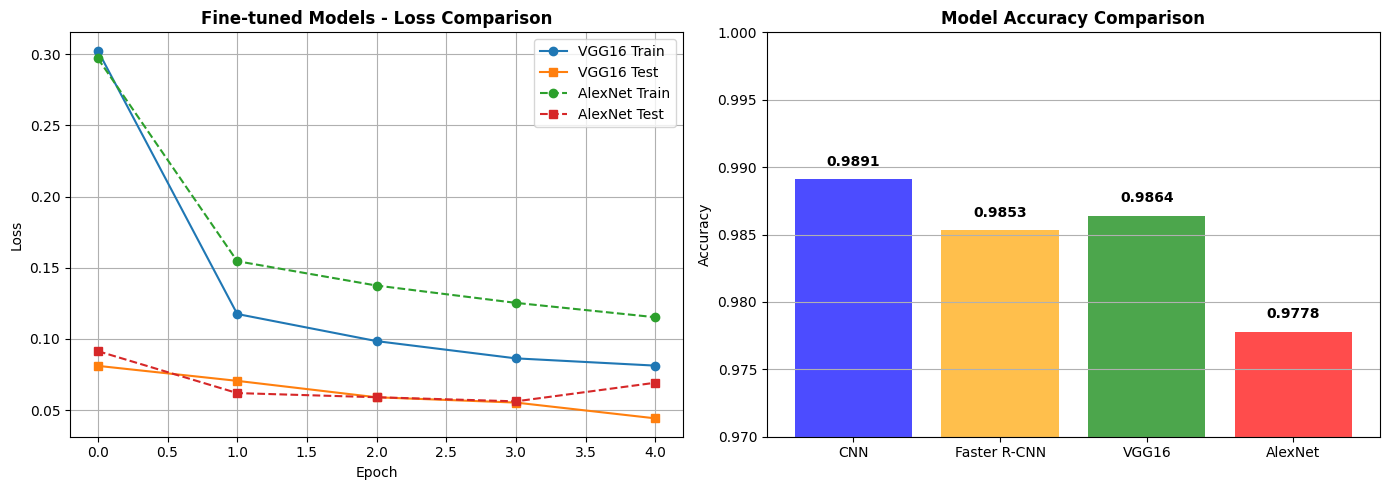


✓ Fine-tuning complete!


In [13]:
# ==================== VISUALIZATION ====================
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# VGG16 Loss
axes[0].plot(vgg16_train_loss, label='VGG16 Train', marker='o')
axes[0].plot(vgg16_test_loss, label='VGG16 Test', marker='s')
axes[0].plot(alex_train_loss, label='AlexNet Train', marker='o', linestyle='--')
axes[0].plot(alex_test_loss, label='AlexNet Test', marker='s', linestyle='--')
axes[0].set_title('Fine-tuned Models - Loss Comparison', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid()

# Accuracy comparison bar chart
models = ['CNN', 'Faster R-CNN', 'VGG16', 'AlexNet']
accuracies = [cnn_final_acc, frcnn_final_acc, vgg16_final_acc, alex_final_acc]
colors = ['blue', 'orange', 'green', 'red']

axes[1].bar(models, accuracies, color=colors, alpha=0.7)
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Model Accuracy Comparison', fontsize=12, fontweight='bold')
axes[1].set_ylim([0.97, 1.0])
for i, v in enumerate(accuracies):
    axes[1].text(i, v + 0.001, f'{v:.4f}', ha='center', fontweight='bold')
axes[1].grid(axis='y')

plt.tight_layout()
plt.savefig('fine_tuning_comparison.png', dpi=100)
plt.show()

print("\n✓ Fine-tuning complete!")